# Evaluating a Model with Dataflow and BigQuery

This notebook is the third in the set of steps to run machine learning on the cloud. In this step, we will use the model training in the previous notebook and continue with evaluating the resulting model.

Evaluation is accomplished by first running batch prediction over one or more evaluation datasets. This is done via Cloud Dataflow, and then analyzing the results using BigQuery. Doing evaluation using these services allow you to scale to large evaluation datasets.

## Workspace Setup

The first step is to setup the workspace that we will use within this notebook - the python libraries, and the Google Cloud Storage bucket that will be used to contain the inputs and outputs produced over the course of the steps.

In [3]:
import google.datalab as datalab
import google.datalab.ml as ml
import mltoolbox.regression.dnn as regression
import os

The storage bucket was created earlier. We'll re-declare it here, so we can use it.

In [4]:
storage_bucket = 'gs://' + datalab.Context.default().project_id + '-datalab-workspace/'
storage_region = 'us-central1'

workspace_path = os.path.join(storage_bucket, 'census')
training_path = os.path.join(workspace_path, 'training')

### Model

Lets take a quick look at the model that was previously produced as a result of the training job.

In [5]:
!gsutil ls -r {training_path}/model

gs://data-insights-evanjones-datalab-workspace/census/training/model/:
gs://data-insights-evanjones-datalab-workspace/census/training/model/
gs://data-insights-evanjones-datalab-workspace/census/training/model/saved_model.pb

gs://data-insights-evanjones-datalab-workspace/census/training/model/assets.extra/:
gs://data-insights-evanjones-datalab-workspace/census/training/model/assets.extra/
gs://data-insights-evanjones-datalab-workspace/census/training/model/assets.extra/features.json
gs://data-insights-evanjones-datalab-workspace/census/training/model/assets.extra/schema.json

gs://data-insights-evanjones-datalab-workspace/census/training/model/variables/:
gs://data-insights-evanjones-datalab-workspace/census/training/model/variables/
gs://data-insights-evanjones-datalab-workspace/census/training/model/variables/variables.data-00000-of-00001
gs://data-insights-evanjones-datalab-workspace/census/training/model/variables/variables.index


## Batch Prediction

We'll submit a batch prediction Dataflow job, to use this model by loading it into TensorFlow, and running it in `evaluation` mode (the mode that expects the input data to contain a value for target). The other mode, `prediction`, is used to predict over data where the target column is missing.

**NOTE**: Batch prediction can take a few minutes to launch while compute resources are provisioned. In the case of large datasets in real-world problems, this overhead is a much smaller part of the overall job lifetime.

In [6]:
eval_data_path = os.path.join(workspace_path, 'data/eval.csv')
evaluation_path = os.path.join(workspace_path, 'evaluation')

regression.batch_predict(training_dir=training_path, prediction_input_file=eval_data_path,
                         output_dir=evaluation_path,
                         mode='evaluation',
                         output_format='csv',
                         cloud=True)

Building package and uploading to gs://data-insights-evanjones-datalab-workspace/census/evaluation/staging/trainer.tar.gz


/usr/local/lib/python2.7/dist-packages/oauth2client/contrib/gce.py:99: UserWarning: You have requested explicit scopes to be used with a GCE service account.
Using this argument will have no effect on the actual scopes for tokens
requested. These scopes are set at VM instance creation time and
can't be overridden in the request.

  warnings.warn(_SCOPES_WARNING)
/usr/local/lib/python2.7/dist-packages/apache_beam/io/gcp/gcsio.py:113: DeprecationWarning: object() takes no parameters
  super(GcsIO, cls).__new__(cls, storage_client))
/usr/local/lib/python2.7/dist-packages/scipy/ndimage/measurements.py:36: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _ni_label
/usr/local/lib/python2.7/dist-packages/scipy/ndimage/measurements.py:36: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  from . import _ni_label


INFO:tensorflow:Restoring parameters from gs://data-insights-evanjones-datalab-workspace/census/training/evaluation_model/variables/variables


INFO:tensorflow:Restoring parameters from gs://data-insights-evanjones-datalab-workspace/census/training/evaluation_model/variables/variables


Dataflow Job submitted, see Job mltoolbox-batch-prediction-20171231214820 at https://console.developers.google.com/dataflow?project=data-insights-evanjones


/usr/local/lib/python2.7/dist-packages/apache_beam/coders/typecoders.py:135: UserWarning: Using fallback coder for typehint: Any.
  warnings.warn('Using fallback coder for typehint: %r.' % typehint)


Batch predict: completed


Once prediction is done, the individual predictions will be written out into Cloud Storage.

In [7]:
!gsutil ls {evaluation_path}

gs://data-insights-evanjones-datalab-workspace/census/evaluation/csv_schema.json
gs://data-insights-evanjones-datalab-workspace/census/evaluation/errors-00000-of-00001.txt
gs://data-insights-evanjones-datalab-workspace/census/evaluation/predictions-00000-of-00003.csv
gs://data-insights-evanjones-datalab-workspace/census/evaluation/predictions-00001-of-00003.csv
gs://data-insights-evanjones-datalab-workspace/census/evaluation/predictions-00002-of-00003.csv
gs://data-insights-evanjones-datalab-workspace/census/evaluation/staging/
gs://data-insights-evanjones-datalab-workspace/census/evaluation/tmp/


In [8]:
!gsutil cat {evaluation_path}/csv_schema.json
!gsutil -q -m cp -r {evaluation_path}/ /tmp
!head -n 5 /tmp/evaluation/predictions-00000*

[
  {
    "type": "STRING", 
    "mode": "NULLABLE", 
    "name": "SERIALNO"
  }, 
  {
    "type": "FLOAT", 
    "mode": "NULLABLE", 
    "name": "predicted"
  }, 
  {
    "type": "FLOAT", 
    "mode": "NULLABLE", 
    "name": "target"
  }
]
1438,17.628030777,45.0
2892,17.628030777,16.0
3761,17.628030777,15.0
4767,17.628030777,58.0
8625,17.628030777,22.3999996185


## Analysis with BigQuery

We're going to use BigQuery to do evaluation. BigQuery can directly work against CSV data in Cloud Storage. However, if you have very large evaluation results, or you're going to be running multiple queries, it is advisable to first load the results into a BigQuery table.

In [9]:
%bq datasource --name eval_results --paths {storage_bucket}census/evaluation/predictions*
{
  "schema": [
    {
      "type": "STRING", 
      "mode": "nullable", 
      "name": "SERIALNO"
    }, 
    {
      "type": "FLOAT", 
      "mode": "nullable", 
      "name": "predicted_target"
    }, 
    {
      "type": "FLOAT", 
      "mode": "nullable", 
      "name": "target_from_input"
    }
  ]
}

In [10]:
%bq query --datasource eval_results
SELECT SQRT(AVG(error)) AS rmse FROM (
  SELECT POW(target_from_input - predicted_target, 2) AS error
  FROM eval_results
)

rmse
30.7954509872


In [11]:
%bq query --name distribution_query --datasource eval_results
WITH errors AS (
  SELECT predicted_target - target_from_input AS error
  FROM eval_results
),
error_stats AS (
  SELECT MIN(error) AS min_error, MAX(error) - MIN(error) AS error_range FROM errors
),
quantized_errors AS (
  SELECT error, FLOOR((error - min_error) * 20 / error_range) error_bin FROM errors CROSS JOIN error_stats
)
SELECT AVG(error) AS error, COUNT(error_bin) AS instances
FROM quantized_errors
GROUP BY error_bin
ORDER BY error_bin

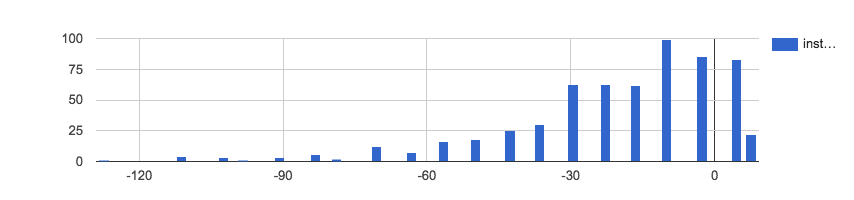

In [12]:
%chart columns --data distribution_query --fields error,instances

As shown with the queries and chart, SQL and BigQuery can be used to analyze large evaluation results to understand how the model performs. In this case, the error as well as distribution of errors.

## Next Steps

We're almost done. Now that we have a model, our next step will be to deploy it and use it for predictions. This will be covered in the [next notebook](./5%2BService%2BPredict.ipynb).